# Реализован конвейер с использованием  EasyOCR  и Spylls для

1.   List item
2.   List item

корректировки ошибок.

# Load dataset from Kaggle

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# upload kaggle.json to /content folder
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"viktorsok92","key":"d6c6654c6fa16e9da730c3889de0a939"}'}

In [ ]:
# create folders in root and give permissions
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download dataset
!kaggle competitions download benetech-making-graphs-accessible

100% 979M/982M [00:12<00:00, 66.2MB/s]
100% 982M/982M [00:12<00:00, 85.7MB/s]


In [ ]:
# unzip
import zipfile
zip_ref = zipfile.ZipFile('benetech-making-graphs-accessible.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Apply Easy OCR on one image for testing

In [ ]:
%%capture
!pip install easyocr

In [ ]:
# Import the library
import easyocr

# Load the model for English language and choose device to run it on
reader = easyocr.Reader(['en'], gpu = False)

In [ ]:
from IPython.display import Image
import requests

def show_image(image_name):
  return Image(filename=image_name)


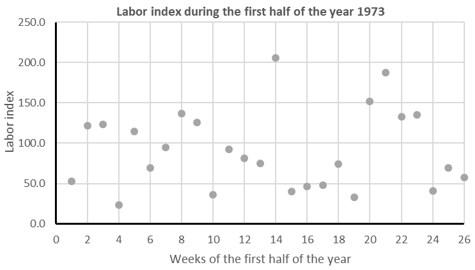

In [ ]:
image = "train/images/32f3a9184524.jpg" # pick random image
show_image(image)

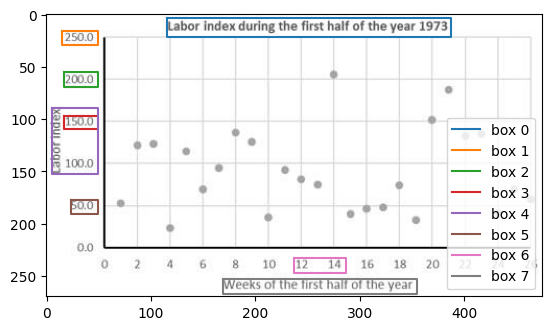

In [ ]:
#res = reader.readtext(image, paragraph=False, slope_ths= 4, ycenter_ths  = 2 , width_ths = 0.8 , height_ths = 3)
res = reader.readtext(image, paragraph=True, ycenter_ths  = 0.1)
img = plt.imread(image)
plt.imshow(img)
for i,r in enumerate(res):
  bbox = np.array(r[0]).T
  bbox = np.hstack((bbox, bbox[:,0].reshape(-1,1)))
  plt.plot(bbox[0], bbox[1])
  #plt.figtext(0.5
plt.legend(["box " +  n for n in list(map(str, range(len(res))))]) # numerate the bounding boxes

In [ ]:
recognized = {}
for i,r in enumerate(res):
  for w in r[1].split():
    if w.strip().isalpha():
      key = "box " + str(i)
      if recognized.get(key) is None:
        recognized[key] = list()
      recognized[key].append(w)


In [ ]:
for k,v in recognized.items():
  print(f"Bounding Box Number: {k}, Words: {v} \n")

Bounding Box Number: box 0, Words: ['Labor', 'index', 'during', 'the', 'first', 'half', 'of', 'the', 'year'] 

Bounding Box Number: box 7, Words: ['Weeks', 'of', 'the', 'first', 'half', 'of', 'the', 'year'] 



# Usage of Spylls spell-checker

In [ ]:
%%capture
!pip install spylls

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.0 MB/s eta 0:00:00


In [ ]:
from spylls.hunspell import Dictionary

# en_US dictionary is distributed with spylls
# See docs to load other dictionaries
dictionary = Dictionary.from_files('en_US')

In [ ]:
dictionary.lookup("natioanl")

False

In [ ]:
next(dictionary.suggest("natioanl"))

'national'

In [ ]:
corrected = {}
for box, words in recognized.items():
  for word in words:
     if corrected.get(box) is None:
        corrected[box] = list()
     corrected[box].append(word if dictionary.lookup(w) else next(dictionary.suggest(w))) # correct the word if it's not in dictionary with the most probable suggestion


In [ ]:
print(f"Recognized: {'='*50} \n")
for k,v in recognized.items():
  print(f"{k}: {v} \n")
print(f"Corrected: {'='*50} \n")
for k,v in corrected.items():
  print(f"{k}: {v} \n")

Recognized: ================================================== 

box 0: ['Labor', 'index', 'during', 'the', 'first', 'half', 'of', 'the', 'year'] 

box 7: ['Weeks', 'of', 'the', 'first', 'half', 'of', 'the', 'year'] 

Corrected: ================================================== 

box 0: ['Labor', 'index', 'during', 'the', 'first', 'half', 'of', 'the', 'year'] 

box 7: ['Weeks', 'of', 'the', 'first', 'half', 'of', 'the', 'year'] 



# Putting all together into OCR-Spell-Checker Pipeline

In [ ]:
%%capture
!pip install spylls easyocr

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import easyocr
from spylls.hunspell import Dictionary

In [ ]:
class OCR_Spell_Check:
  """
  Class implements a pipeline from
  OCR to spell-checking and also
  provide some visualization
  """
  def __init__(self, reader, dictionary):
    self.reader = reader
    self.dictionary = dictionary

  def recognize(self, path_to_image):
    """
    Apply OCR and the spell-correction
    Returns corrected recognized text
    """
    self.path_to_image = path_to_image
    self.res = self.reader.readtext(path_to_image, paragraph=True)
    self.recognized = {}
    for i,r in enumerate(self.res):
      for w in r[1].split():
        if w.strip().isalpha():
          key = "box " + str(i)
          if self.recognized.get(key) is None:
            self.recognized[key] = list()
          self.recognized[key].append(w)
    self.corrected = self.__correct()
    return self.corrected

  def __correct(self):
    """
    Private class for spell-correction
    """
    corrected = {}
    for box, words in self.recognized.items():
      for word in words:
        if corrected.get(box) is None:
            corrected[box] = list()
        corrected[box].append(word if self.dictionary.lookup(word) else next(self.dictionary.suggest(word))) # correct the word if it's not in dictionary with the most probable suggestion
    return corrected

  def plot_bounding_boxes(self):
    """
    Plots bounding boxes around recognized text regions
    """
    img = plt.imread(self.path_to_image)
    plt.imshow(img)
    for i,r in enumerate(self.res):
      bbox = np.array(r[0]).T
      bbox = np.hstack((bbox, bbox[:,0].reshape(-1,1)))
      plt.plot(bbox[0], bbox[1])
      #plt.figtext(0.5
    plt.legend(["box " +  n for n in list(map(str, range(len(self.res))))]) # numerate the bounding boxes

  def spell_corrector_res(self):
    """
    Prints out the result of spell-corrector for testing
    """
    print(f"{'='*25} Recognized {'='*25} \n")
    for k,v in self.recognized.items():
      print(f"{k}: {v} \n")
    print(f"{'='*25} Corrected {'='*25} \n")
    for k,v in self.corrected.items():
      print(f"{k}: {v} \n")


In [ ]:
import os
import random

def get_random_img(path):
  images = os.listdir(path)
  return path + random.choice(images)

In [ ]:
reader = easyocr.Reader(['en'], gpu = False)
dictionary = Dictionary.from_files('en_US')
model = OCR_Spell_Check(reader, dictionary)

========================= Recognized ========================= 

box 0: ['Share', 'of', 'female', 'population', 'in'] 

box 1: ['Arabia', 'Senegal', 'Sevchelles', 'Leone', 'Singapore', 'wakia', 'eria', 'Small', 'states', 'Islands', 'Solomon', 'Country'] 

========================= Corrected ========================= 

box 0: ['Share', 'of', 'female', 'population', 'in'] 

box 1: ['Arabia', 'Senegal', 'Seychelles', 'Leon', 'Singapore', 'Waikiki', 'era', 'Small', 'states', 'Islands', 'Solomon', 'Country'] 



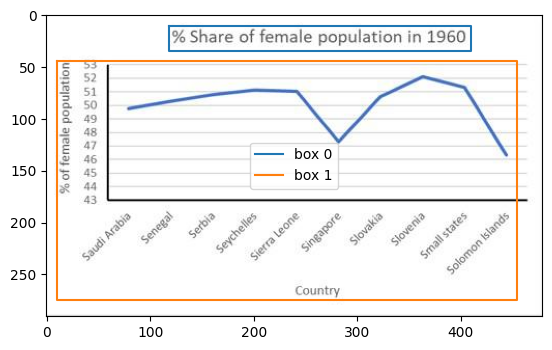

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()

========================= Recognized ========================= 

box 0: ['Air', 'quality', 'Measures', 'on', 'the', 'national'] 

box 1: ['environmental', 'health', 'tracking', 'network', 'in'] 

box 2: ['y', 'Ascension', 'Bossier', 'Caddo', 'Calcasieu', 'Rouge', 'Iberville', 'Livingston', 'Orleans', 'Quachita', 'Coupee', 'Bernar', 'Charles', 'Iton', 'E', 'Pointe', 'East', 'COUNTPY'] 

========================= Corrected ========================= 

box 0: ['Air', 'quality', 'Measures', 'on', 'the', 'national'] 

box 1: ['environmental', 'health', 'tracking', 'network', 'in'] 

box 2: ['y', 'Ascension', 'Bossier', 'Cad do', 'Calcareous', 'Rouge', 'Libreville', 'Livingston', 'Orleans', 'Chiquita', 'Toupee', 'Bernard', 'Charles', 'Ton', 'E', 'Point', 'East', 'COUNTY'] 



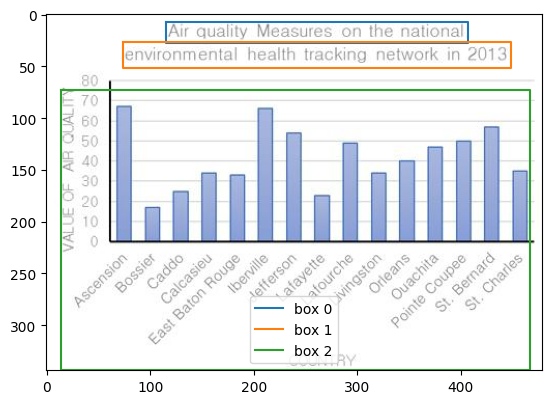

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()

========================= Recognized ========================= 

box 0: ['Rural', 'population', 'with', 'projections', 'in', 'the', 'Year'] 

box 1: ['L'] 

box 4: ['Seregal', 'Serbia', 'Seychelles', 'Leone', 'Singapore', 'wakia', 'Slov', 'wenia', 'Solomon', 'Islands', 'Somalia', 'Sierra', 'Sint', 'Maarten', 'Country'] 

========================= Corrected ========================= 

box 0: ['Rural', 'population', 'with', 'projections', 'in', 'the', 'Year'] 

box 1: ['L'] 

box 4: ['Senegal', 'Serbia', 'Seychelles', 'Leon', 'Singapore', 'Waikiki', 'Slav', 'weenie', 'Solomon', 'Islands', 'Somalia', 'Sierra', 'Int', 'Marten', 'Country'] 



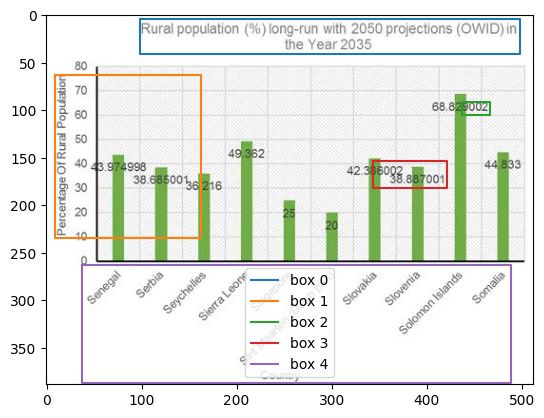

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()

========================= Recognized ========================= 

box 0: ['Deaths', 'Malaria', 'Both', 'years', 'for', 'the', 'year'] 

box 1: ['Country'] 

box 2: ['North', 'Korea', 'Macedonia', 'Ireland', 'Islands', 'arway', 'Countries', 'Oman', 'Pakistan', 'Palau', 'America', 'North', 'E', 'Northern', 'Matlana', 'OECD', 'Jrthern', 'E'] 

========================= Corrected ========================= 

box 0: ['Deaths', 'Malaria', 'Both', 'years', 'for', 'the', 'year'] 

box 1: ['Country'] 

box 2: ['North', 'Korea', 'Macedonia', 'Ireland', 'Islands', 'away', 'Countries', 'Oman', 'Pakistan', 'Paula', 'America', 'North', 'E', 'Northern', 'Mazatlan', 'OED', 'Northern', 'E'] 



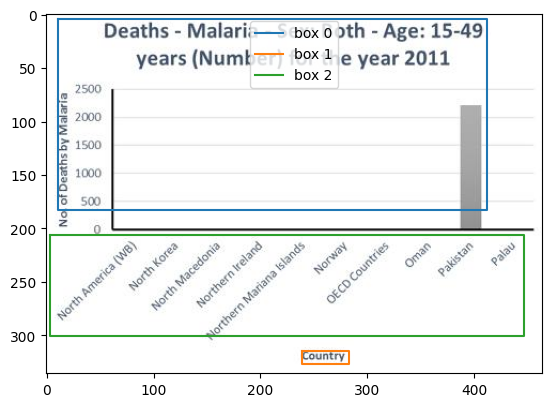

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()

========================= Recognized ========================= 

box 0: ['Rural', 'population', 'with', 'projections', 'in', 'the', 'Year'] 

box 1: ['L', 'Melanesia', 'Mexico', 'couniries', 'Moldov', 'Monaco', 'Middle', 'Mongolia', 'Montenegro', 'Micronesia', 'Country'] 

========================= Corrected ========================= 

box 0: ['Rural', 'population', 'with', 'projections', 'in', 'the', 'Year'] 

box 1: ['L', 'Melanesia', 'Mexico', 'countries', 'Moldova', 'Monaco', 'Middle', 'Mongolia', 'Montenegro', 'Micronesia', 'Country'] 



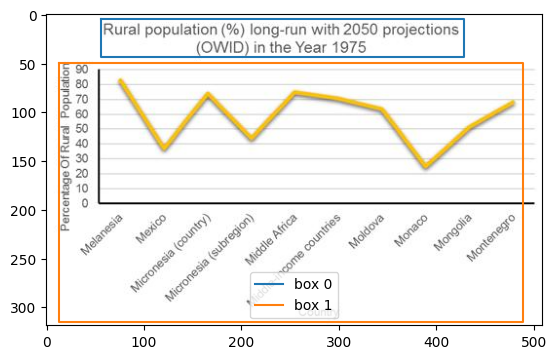

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()

========================= Recognized ========================= 

box 0: ['Sex', 'ratio', 'by', 'age', 'year', 'in', 'the', 'vear'] 

box 2: ['Tajikistan', 'Tanzania', 'Thadand', 'Timor', 'Toro', 'Tonea', 'Tobago', 'Tunisla', 'Turkey', 'Trinidad', 'COUNTRY'] 

========================= Corrected ========================= 

box 0: ['Sex', 'ratio', 'by', 'age', 'year', 'in', 'the', 'bear'] 

box 2: ['Tajikistan', 'Tanzania', 'Thad and', 'Timor', 'Toto', 'Tonia', 'Tobago', 'Tunisia', 'Turkey', 'Trinidad', 'COUNTRY'] 



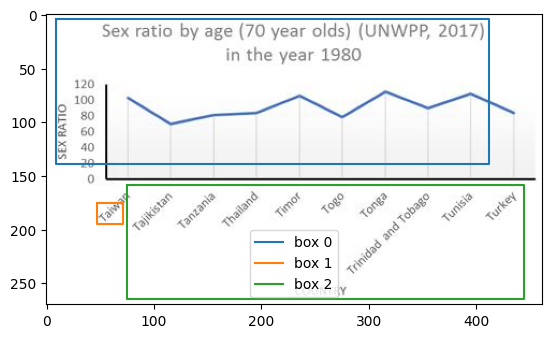

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()

========================= Recognized ========================= 

box 0: ['Sex', 'ratio', 'by', 'age', 'year', 'in', 'the', 'Year'] 

box 2: ['Tajikistan', 'Tanzania', 'Thailand', 'Togo', 'Tonga', 'Tobago', 'Turkey', 'Trinidad', 'COUNTRY'] 

========================= Corrected ========================= 

box 0: ['Sex', 'ratio', 'by', 'age', 'year', 'in', 'the', 'Year'] 

box 2: ['Tajikistan', 'Tanzania', 'Thailand', 'Togo', 'Tonga', 'Tobago', 'Turkey', 'Trinidad', 'COUNTRY'] 



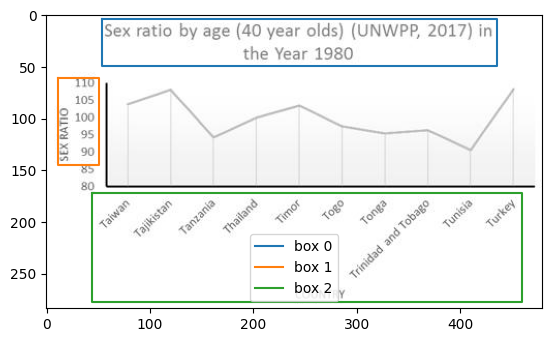

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()

========================= Recognized ========================= 

box 0: ['Urban', 'population', 'future', 'projection', 'for', 'the', 'Year', 'L', 'SOOOOOO', 'Armenia', 'Aruba', 'Australia', 'Austria', 'rbaijan', 'Bahamas', 'Bahrain', 'J', 'Country'] 

========================= Corrected ========================= 

box 0: ['Urban', 'population', 'future', 'projection', 'for', 'the', 'Year', 'L', 'SOOTY', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'J', 'Country'] 



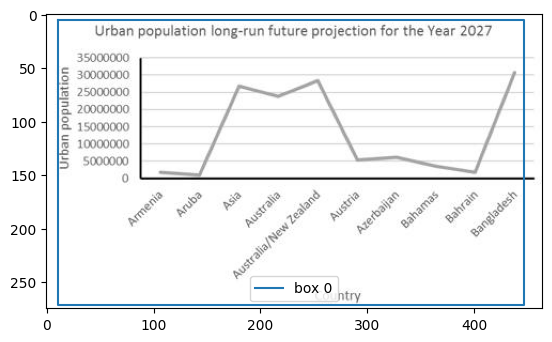

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()

========================= Recognized ========================= 

box 0: ['Sex', 'ratio', 'by', 'age', 'year', 'in', 'countries'] 

box 5: ['Years'] 

========================= Corrected ========================= 

box 0: ['Sex', 'ratio', 'by', 'age', 'year', 'in', 'countries'] 

box 5: ['Years'] 



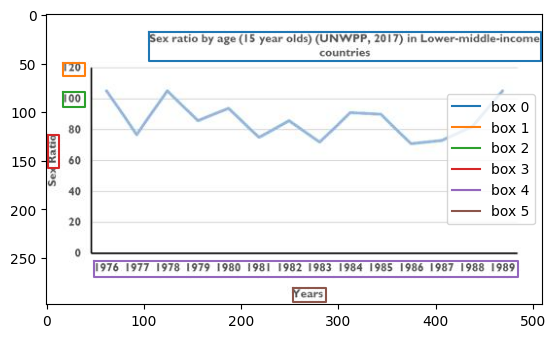

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()

========================= Recognized ========================= 

box 0: ['GDP', 'per', 'capita', 'Share', 'Cereals', 'allocated', 'for', 'Spain', 'Irom'] 

box 2: ['ACcmo'] 

box 4: ['Shatg', 'Ol', 'cerealy', 'Tood'] 

========================= Corrected ========================= 

box 0: ['GDP', 'per', 'capital', 'Share', 'Cereals', 'allocated', 'for', 'Spain', 'Prom'] 

box 2: ['Monaco'] 

box 4: ['Shag', 'L', 'cereal', 'Tod'] 



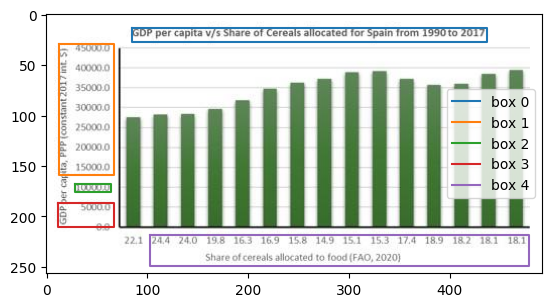

In [ ]:
out = model.recognize(get_random_img("train/images/"))
model.plot_bounding_boxes()
model.spell_corrector_res()